# GeoDistance check of OWDs

In [1]:
%matplotlib inline

import requests
import math

try: import simplejson as json
except ImportError: import json

from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather-*"

my_query = {}
OWDpos={}

In [2]:
query={
   "size": 0,
   "query": {
    "bool": {
      "must": [
        {"term": { "_type" : "latency"}}
      ],
      "filter" : {
        'range': {'timestamp': {'gte': '20161001T000000+0000'}}
      }
    }
   },
    "aggs" : {
      "src" : {
        "terms" : { "field" : "src", "size": 1000 },
        "aggs" : {
          "dest" : {
            "terms" : {"field" : "dest", "size": 1000},
            "aggs" : {
              "avgde" : {
                "avg" :{ "field" : "delay_mean" }
              }
          }
        }
      }
    }
    }        
}

res = es.search(index=my_index, body=query, request_timeout=120)

In [3]:
def getServerLongLat(ip):
    
    if ip in OWDpos:
        return OWDpos[ip]
    
    try:
        req = requests.get("http://geoip.mwt2.org:4288/json/"+ip, None)
        res=req.json()
        lon=res['longitude']
        lat=res['latitude']
        pos=[lon,lat]
        OWDpos[ip]=pos
        return pos
    except:
        pass
#         print ("Can't determine coordinates. Trying next one.", ip)
        
    try:
        req = requests.get("http://freegeoip.net/json/"+ip, None)
        res=req.json()
        lon=res['longitude']
        lat=res['latitude']
        pos=[lon,lat]
        OWDpos[ip]=pos
        return pos
    except:
        print ("Can't determine coordinates", ip)
        

In [4]:
def getDistance(ip1,ip2):
    p1=getServerLongLat(ip1)
    p2=getServerLongLat(ip2)
    if not p1 or not p2: return 0.0
    dlon = math.radians(p1[0] - p2[0])
    dlat = math.radians(p1[1] - p2[1])
    a = pow(math.sin(dlat/2),2) + math.cos(math.radians(p2[1])) * math.cos(math.radians(p1[1])) * pow(math.sin(dlon/2),2)
    c = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) )
    d = 6373 * c # 6373 is the radius of the Earth in km
    return d            

In [5]:
ser = res['aggregations']['src']['buckets']
count=10
src=[]
dest=[]
docs=[]
dist=[]
owd=[]
for s in ser:
    des=s['dest']['buckets']
    for d in des:
        delay = d['avgde']['value']
        distance = getDistance(s['key'], d['key'])
        
        src.append( s['key'])
        dest.append(d['key'])
        docs.append(d['doc_count'])
        dist.append(distance)
        owd.append( delay)
        
        if count>0:
            count -= 1
            print ( s['key'], '->', d['key'], '\tdocs:', d['doc_count'], '\tAvg OWD: {:.2f}   Dist:{:.1f}'.format(delay, distance))
        

192.108.47.12 -> 163.1.5.210 	docs: 281017 	Avg OWD: 25.10   Dist:747.9
192.108.47.12 -> 129.107.255.29 	docs: 157706 	Avg OWD: 65.75   Dist:8337.8
192.108.47.12 -> 134.79.118.72 	docs: 51465 	Avg OWD: 77.72   Dist:9241.4
192.108.47.12 -> 192.54.207.250 	docs: 44667 	Avg OWD: 10.61   Dist:441.2
192.108.47.12 -> 192.101.107.152 	docs: 42028 	Avg OWD: 81.08   Dist:8275.9
192.108.47.12 -> 131.225.2.47 	docs: 31628 	Avg OWD: 55.87   Dist:7064.2
192.108.47.12 -> 129.215.213.70 	docs: 30551 	Avg OWD: 29.24   Dist:1098.6
192.108.47.12 -> 145.100.17.8 	docs: 27980 	Avg OWD: 15.22   Dist:445.1
192.108.47.12 -> 192.5.207.251 	docs: 24936 	Avg OWD: 53.90   Dist:5934.4
192.108.47.12 -> 192.41.236.31 	docs: 20056 	Avg OWD: 60.44   Dist:6743.8


In [6]:
data = pd.DataFrame({'src':src, 'dest':dest, 'docs':docs, 'owd':owd, 'dist':dist})
print(data.shape)
data.head()

(6350, 5)


,dest,dist,docs,owd,src
0,163.1.5.210,747.861116,281017,25.095859,192.108.47.12
1,129.107.255.29,8337.773231,157706,65.746924,192.108.47.12
2,134.79.118.72,9241.392781,51465,77.717391,192.108.47.12
3,192.54.207.250,441.227506,44667,10.613673,192.108.47.12
4,192.101.107.152,8275.868357,42028,81.077284,192.108.47.12


In [7]:
#cleaning up ones with not many measurements
data=data[data.docs > 100]

#adding "packet speed in terms of speed of light"
data['speed']=data['dist']/data['owd']/300
print(data.shape)
data.describe()

(6322, 6)


,dist,docs,owd,speed
count,6322.000000,6322.000000,6322.000000,6322.000000
mean,4487.559246,12702.644733,55.900414,0.312043
std,3875.157944,17348.076446,271.939135,0.806169
min,0.000000,116.000000,-2422.866444,-15.574939
25%,1028.970652,10659.250000,17.648485,0.172608
50%,2575.945823,13038.000000,40.032034,0.274063
75%,7675.033434,13122.750000,76.547782,0.359890
max,19065.338076,600246.000000,2733.341078,33.210513


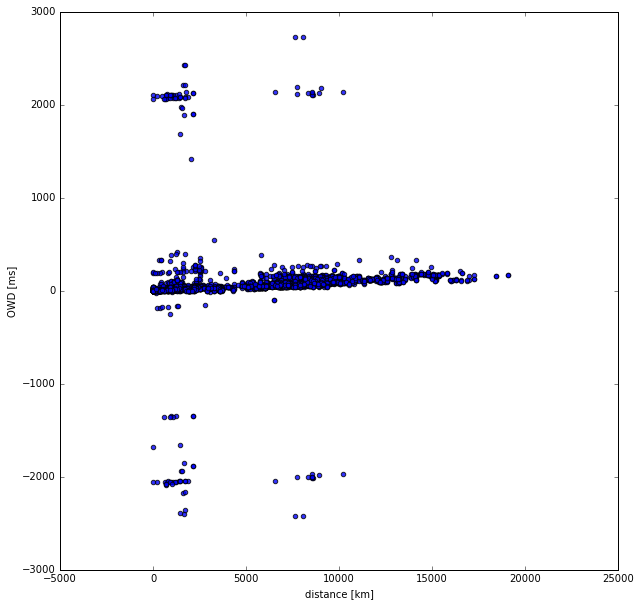

In [8]:
plt.figure(figsize=[10, 10])
plt.scatter( data.dist, data.owd ,alpha=0.8)
plt.xlabel('distance [km]')
plt.ylabel('OWD [ms]')
plt.show()

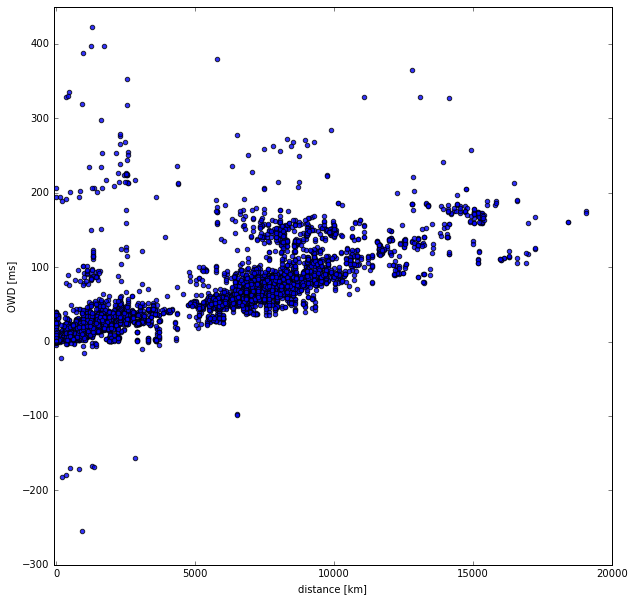

In [9]:
plt.figure(figsize=[10, 10])
plt.scatter( data.dist, data.owd ,alpha=0.8)
plt.xlabel('distance [km]')
plt.ylabel('OWD [ms]')

plt.ylim([-300,450])
plt.xlim([-100,20000])
plt.show()

In [10]:
# find the worst
grouped = data.groupby('src')
grouped.head()

,dest,dist,docs,owd,src,speed
0,163.1.5.210,747.861116,281017,25.095859,192.108.47.12,0.099334
1,129.107.255.29,8337.773231,157706,65.746924,192.108.47.12,0.422721
2,134.79.118.72,9241.392781,51465,77.717391,192.108.47.12,0.396367
3,192.54.207.250,441.227506,44667,10.613673,192.108.47.12,0.138572
4,192.101.107.152,8275.868357,42028,81.077284,192.108.47.12,0.340246
88,194.36.11.38,0.000000,566527,1.350913,128.40.4.25,0.000000
89,130.246.47.129,89.250258,455361,2.002619,128.40.4.25,0.148556
90,139.184.80.18,3.003479,405307,2.827600,128.40.4.25,0.003541
91,131.111.66.196,77.631000,272259,2.923346,128.40.4.25,0.088518
92,130.246.47.129,87.175000,600246,3.724262,139.184.80.18,0.078024


In [11]:
#grouped.agg({'speed' : 'mean', 'owd' : ['mean','count'] })

tmp={"src":[],"owd":[], "count":[], "speed":[]}
for name, group in grouped:
   print(name, group.owd.count(), group.owd.mean())
   if group.owd.count()>2 and group.owd.mean()>200:
        tmp['src'].append(name)
        tmp['owd'].append(group.owd.mean())
        tmp['count'].append(group.owd.count())
        tmp['speed'].append(group.speed.mean())

109.105.124.86 19 -32.61987755905557
109.105.125.232 46 6.8386509146023
117.103.105.191 66 144.79489626203613
128.111.174.187 1 2.4184405403247666
128.114.109.66 1 4.9859215289181
128.119.3.105 1 25.061673804493488
128.120.80.78 1 5.489973349349859
128.125.214.141 1 1.1838021626433999
128.142.223.247 86 21.45552884191442
128.211.143.3 10 -164.43910059809724
128.227.221.44 37 79.01507007685622
128.3.127.4 1 0.15809680260264009
128.40.4.25 4 2.27611951485816
128.55.199.18 5 17.63085027616295
129.107.255.26 7 16.40631365382374
129.107.255.29 65 67.58590731285129
129.114.0.189 1 3.908663789107059
129.15.40.231 65 68.75285493930546
129.215.213.70 83 16.81195983150088
129.7.131.250 1 2.435516911563022
129.93.227.118 1 3.356391726135957
129.93.239.148 51 23.368892965793936
129.93.5.165 7 13.734814763344515
130.126.0.109 1 25.256932547645093
130.191.49.100 1 2.3411918891322063
130.209.239.124 74 38.688700333021885
130.246.176.109 95 42.035724715634295
130.246.182.100 16 4.572074366163146
130.2

In [12]:
tm=pd.DataFrame(tmp)
tm.sort_values('owd')

,count,owd,speed,src
0,38,2087.707618,0.004564,192.135.14.32
1,19,2144.290724,0.004832,2001:760:4224:1::32


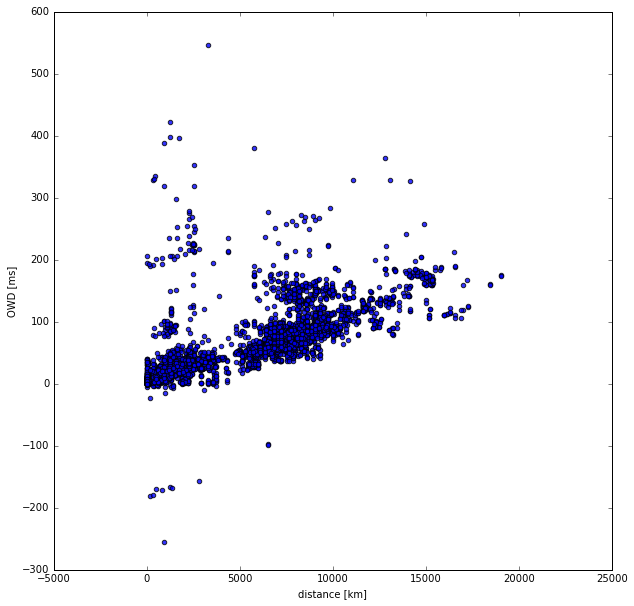

In [13]:
data=data[data.src!='192.135.14.32']
data=data[data.src!='2001:760:4224:1::32']
data=data[data.dest!='192.135.14.32']
data=data[data.dest!='2001:760:4224:1::32']

plt.figure(figsize=[10, 10])
plt.scatter( data.dist, data.owd ,alpha=0.8)
plt.xlabel('distance [km]')
plt.ylabel('OWD [ms]')
plt.show()

In [14]:
# second iteration

grouped = data.groupby('src')
tmp={"src":[],"owd":[],"count":[]}
for name, group in grouped:
   if group.owd.count()>2:
        tmp['src'].append(name)
        tmp['owd'].append(group.owd.mean())
        tmp['count'].append(group.owd.count())
        
tm=pd.DataFrame(tmp)
tm.sort_values('owd')

,count,owd,src
4,10,-164.439101,128.211.143.3
76,3,1.124989,192.170.230.51
6,4,2.276120,128.40.4.25
56,3,2.375544,149.165.225.1
58,3,2.395961,149.165.225.3
16,16,4.572074,130.246.182.100
129,7,6.947340,212.193.96.29
113,6,6.969041,2001:630:441:905::d2
130,3,7.079197,213.131.24.2
147,3,7.901971,85.143.115.59


In [15]:
data[data.src=='128.211.143.3']

,dest,dist,docs,owd,src,speed
5931,200.136.80.20,6497.569212,13121,-97.304445,128.211.143.3,-0.222586
5932,129.93.239.148,823.967623,13115,-171.807304,128.211.143.3,-0.015986
5933,128.227.221.44,1268.656758,13112,-167.097035,128.211.143.3,-0.025308
5934,131.225.205.12,198.493479,13111,-181.694519,128.211.143.3,-0.003642
5935,144.92.180.75,360.238859,13111,-179.916788,128.211.143.3,-0.006674
5936,192.111.108.112,475.951715,13107,-169.524062,128.211.143.3,-0.009359
5937,18.12.1.171,1334.994438,13103,-167.886621,128.211.143.3,-0.026506
5938,200.17.30.135,6497.569212,13091,-98.268497,128.211.143.3,-0.220402
5939,169.228.130.40,2816.821244,13016,-156.125970,128.211.143.3,-0.060140
5940,192.84.86.122,909.318210,8528,-254.765765,128.211.143.3,-0.011897


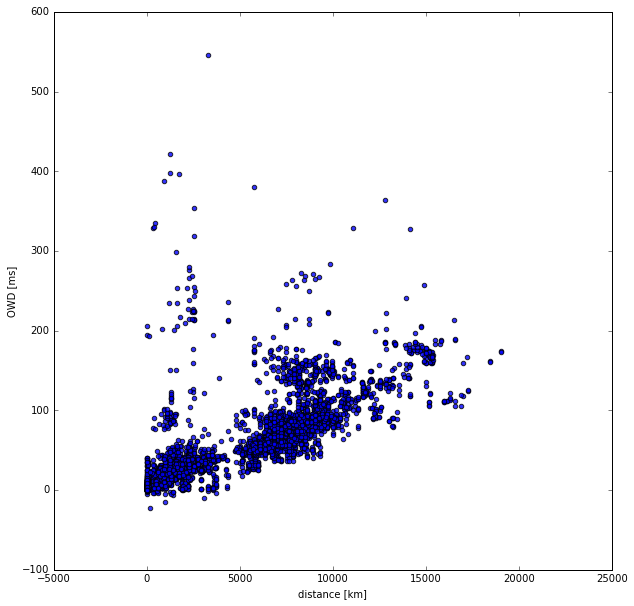

In [16]:
data=data[data.src!='128.211.143.3']
data=data[data.dest!='128.211.143.3']
plt.figure(figsize=[10, 10])
plt.scatter( data.dist, data.owd ,alpha=0.8)
plt.xlabel('distance [km]')
plt.ylabel('OWD [ms]')
plt.show()